In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

In [3]:
from sklearn.metrics import f1_score, roc_auc_score, log_loss, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from eli5.permutation_importance import get_score_importances
import shap
import lightgbm as lgb

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
class TrainTestHelper(object):
    def __init__(self):
        self.ntrain = None

    def combine(self, train, test):
        self.ntrain = train.shape[0]
        if isinstance(train, np.ndarray):
            return np.row_stack((train, test))
        else:
            return train.append(test).reset_index(drop=True)

    def split(self, train_test):
        if self.ntrain is None:
            return None
        if isinstance(train_test, np.ndarray):
            train = train_test[:self.ntrain, :]
            test = train_test[self.ntrain:, :]
        else:
            train = train_test.iloc[:self.ntrain, :].copy().reset_index(drop=True)
            test = train_test.iloc[self.ntrain:, :].copy().reset_index(drop=True)
        return train, test

In [5]:
class MeanEncoder(object):
    def __init__(self, alpha=1, loo=False, noisy=False, noise_std=0, seed=0):
        self.alpha = alpha
        self.loo = loo
        self.noisy = noisy
        self.noise_std = noise_std
        self.seed = np.random.RandomState(seed)
    
    # fit
    def fit_column(self, X, y, col):
        self.target_sums[col] = y.groupby(X[col]).sum()
        self.target_counts[col] = y.groupby(X[col]).count()        
        
    def fit(self, X, y, cats):
        self.global_mean = np.mean(y)
        self.global_std = np.std(y) if self.noise_std is None else self.noise_std
        self.target_sums = {}
        self.target_counts = {}
        for col in cats:
            self.fit_column(X, y, col)
    
    # fit_transform
    def fit_transform_column(self, X, y, col):
        self.target_sums[col] = y.groupby(X[col]).sum()
        self.target_counts[col] = y.groupby(X[col]).count()
        
        if self.noisy:
            reg = self.seed.normal(loc=self.global_mean * self.alpha,
                                     scale=self.global_std * np.sqrt(self.alpha),
                                     size=len(y))
        else:
            reg = self.global_mean * self.alpha
        
        X_res_num = X[col].map(self.target_sums[col]) + reg
        X_res_den = X[col].map(self.target_counts[col]) + self.alpha
        
        if self.loo:
            X_res_num -= y
            X_res_den -= 1
        
        return (X_res_num / X_res_den).values
            
    def fit_transform(self, X, y, cats):
        self.global_mean = np.mean(y)
        self.global_std = np.std(y) if self.noise_std is None else self.noise_std
        self.target_sums = {}
        self.target_counts = {}
        X_res = pd.DataFrame()
        
        for col in cats:
            X_res[col + '_mean_y'] = self.fit_transform_column(X, y, col)
        
        return X_res
    
    # transform
    def transform_column(self, Xt, col):
        Xt_res_num = Xt[col].map(self.target_sums[col]).fillna(0) + self.global_mean * self.alpha
        Xt_res_den = Xt[col].map(self.target_counts[col]).fillna(0) + self.alpha
        return (Xt_res_num / Xt_res_den).values
    
    def transform(self, Xt, cats):
        Xt_res = pd.DataFrame()
        for col in cats:
            Xt_res[col + '_mean_y'] = self.transform_column(Xt, col)
        return Xt_res

In [6]:
class LGBWizard(object):
    def __init__(self, params, cvparams):
        self.params = params
        self.cvparams = cvparams
        
    def fit(self, X, y, test, permute=None, get_shap=False):
        
        def score(X, y):
            pred = self.model.predict(X)
            return self.cvparams['metric'](y, pred)
        
        k = 0
        fold_scores = []
        self.fold_preds = []
        self.target = y
        self.feature_names = X.columns
        self.cvpred = np.zeros(X.shape[0])
        self.pred = np.zeros(test.shape[0])
        
        self.split_imp = np.zeros(X.shape[1])
        self.gain_imp = np.zeros(X.shape[1])
        self.perm_imp = np.zeros(X.shape[1])
        self.shap_imp = np.zeros(X.shape[1])
        
        for tr, te in self.cvparams['folds'].split(X, y):
            xtr, xte = X.loc[tr], X.loc[te]
            ytr, yte = y[tr], y[te]
            
            #train_mean_features = mean_enc.fit_transform(xtr, ytr, to_enc)
            #xtr = np.concatenate((xtr, train_mean_features), axis=1)
            
            #test_mean_features = mean_enc.transform(xte, to_enc)
            #xte = np.concatenate((xte, test_mean_features), axis=1)
            
            xtr = lgb.Dataset(xtr, label=ytr)
            xval = lgb.Dataset(xte, label=yte, reference=xtr)
            self.model = lgb.train(self.params, xtr,
                              num_boost_round=self.cvparams['nround'], valid_sets=[xtr, xval],
                              early_stopping_rounds=self.cvparams['stopping'], verbose_eval=self.cvparams['verbose'])
            self.cvpred[te] = self.model.predict(xte)
            self.fold_preds.append(self.model.predict(test))
            fold_scores.append(self.cvparams['metric'](yte, self.cvpred[te]))
            print('Fold {}: {:.5f}'.format(k, fold_scores[-1]))
            
            self.split_imp += self.model.feature_importance(importance_type='split')
            self.gain_imp += self.model.feature_importance(importance_type='gain')
            
            if permute is not None:
                _, local_imp = get_score_importances(score, xte.values, yte, n_iter=permute, random_state=0)
                self.perm_imp += np.mean(local_imp, axis=0)
                
            if get_shap:
                explainer = shap.TreeExplainer(self.model)
                self.shap_imp += np.sum(np.abs(explainer.shap_values(X.loc[tr])), axis=0) #X.loc[tr]
                
            k += 1
        
        self.split_imp /= k
        self.gain_imp /= k
        self.perm_imp /= -1 * k
        self.shap_imp /= k
        self.pred = np.mean(self.fold_preds, axis=0)
        
        print()
        print('Mean score: {:.5f}'.format(np.mean(fold_scores)))
        print('OOF score: {:.5f}'.format(self.cvparams['metric'](y, self.cvpred)))
        print('Std of score: {:.5f}'.format(np.std(fold_scores)))
        print('Mean std of test objects: {:.5f}'.format(np.mean(np.std(self.fold_preds, axis=0))))
    
    def compute_error(self):
        eps = 1e-5
        self.error = pd.DataFrame()
        self.error['MAE'] = np.abs(self.target - self.cvpred)
        self.error['MSE'] = (self.target - self.cvpred) ** 2
        self.error['MAPE'] = np.abs((self.target - self.cvpred) / (self.target + eps))
        self.error['MSPE'] = ((self.target - self.cvpred) / (self.target + eps)) ** 2
        return self.error
    
    def get_importances(self):
        all_imp = pd.DataFrame(index=self.feature_names)
        all_imp['permutation'] = self.perm_imp
        all_imp['shap'] = self.shap_imp
        all_imp['gain'] = self.gain_imp
        all_imp['split'] = self.split_imp
        return all_imp.sort_values(by='permutation', ascending=False)
    
    def plot_prediction(self, size=(12, 7)):
        eps = 0.1
        _, ax = plt.subplots(figsize=size)
        ax.scatter(self.cvpred, self.target, c='#0047ab', alpha=0.3)
        props = {'xlim': (np.min(self.target) - eps, np.max(self.target) + eps),
                 'ylim': (np.min(self.target) - eps, np.max(self.target) + eps),
                 'title': 'OOF Prediction vs Target',
                 'xlabel': 'Prediction',
                 'ylabel': 'Target'}
        ax.set(**props)
        diag, = ax.plot(props['xlim'], props['ylim'], ls='--', c='black')
        plt.show()
        
    def plot_prediction_std(self, size=(15, 5)):
        _, ax = plt.subplots(figsize=size)
        ax.plot(np.std(self.fold_preds, axis=0), c='#0047ab')
        props = {'xlabel': 'test_example',
                 'ylabel': 'std_test_example',
                 'title': 'Stds of test examples'}
        ax.set(**props)
        plt.show()
    
    def plot_importances(self, size=(5, 15)): ######
        _, ax = plt.subplots(figsize=size)#########
        ax.barh(width=self.perm_imp, c='#0047ab')########
        plt.show()######

    def plot_error(self, error_type='MSE', size=(15, 5)):
        _, ax = plt.subplots(figsize=size)
        ax.plot(self.error[error_type], c='#0047ab')
        props = {'xlabel': 'train_example',
                 'ylabel': error_type.lower() + '_train_example',
                 'title': error_type + ' of examples'}
        ax.set(**props)
        plt.show()
    
    def get_error_histogram(self, error_type='MSE', size=(12, 7)):
        _, ax = plt.subplots(figsize=size)
        ax.hist(self.error[error_type], c='#0047ab')
        props = {'xlabel': 'train_set_error',
                 'ylabel': error_type.lower() + '_error_frequency',
                 'title': 'Histogram ' + error_type + ' of examples'}
        ax.set(**props)
        plt.show()

In [7]:
train = pd.read_csv('train_LZdllcl.csv')
test = pd.read_csv('test_2umaH9m.csv')
sub = pd.read_csv('sample_submission_M0L0uXE.csv')
del train['employee_id'], test['employee_id']

In [8]:
print('Train shape:', train.shape)
print('Test shape:', test.shape)

Train shape: (54808, 13)
Test shape: (23490, 12)


### Target

In [9]:
print('Non-zero target values %:', round(train['is_promoted'].mean() * 100, 2))

Non-zero target values %: 8.52


### Department

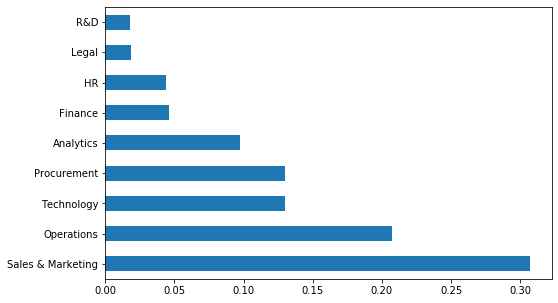

In [10]:
train['department'].value_counts(normalize=True).plot(kind='barh')

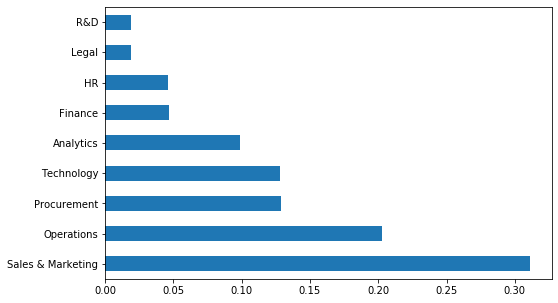

In [11]:
test['department'].value_counts(normalize=True).plot(kind='barh')

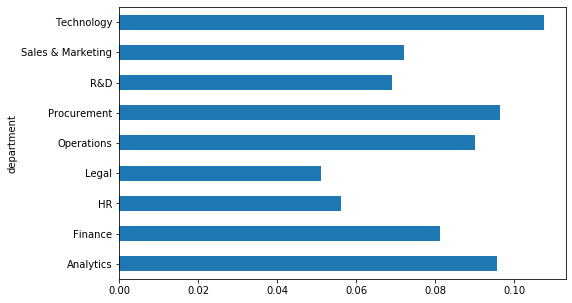

In [12]:
train.groupby('department')['is_promoted'].mean().plot(kind='barh')

### Education

In [13]:
train['education'].value_counts(normalize=True)

Bachelor's          0.699803
Master's & above    0.284834
Below Secondary     0.015363
Name: education, dtype: float64

In [14]:
test['education'].value_counts(normalize=True)

Bachelor's          0.693712
Master's & above    0.289633
Below Secondary     0.016655
Name: education, dtype: float64

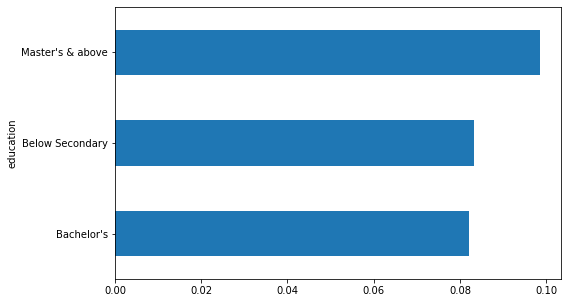

In [15]:
train.groupby('education')['is_promoted'].mean().plot(kind='barh')

### Region

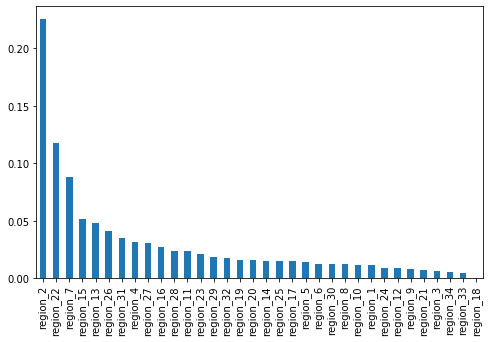

In [16]:
train['region'].value_counts(normalize=True).plot(kind='bar')

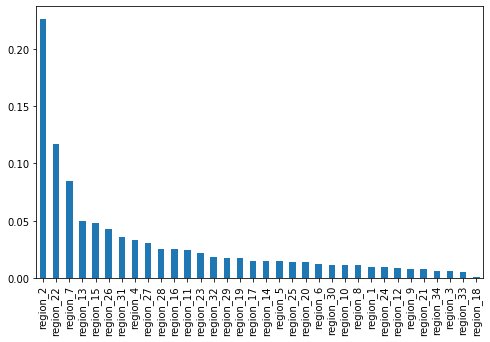

In [17]:
test['region'].value_counts(normalize=True).plot(kind='bar')

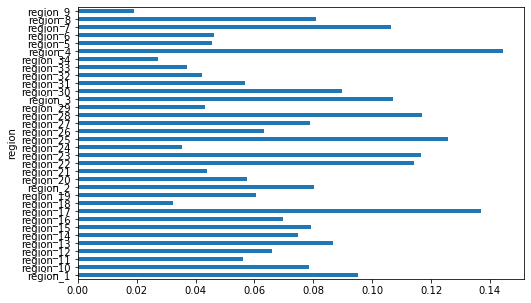

In [18]:
train.groupby('region')['is_promoted'].mean().plot(kind='barh')

### Gender

In [19]:
train['gender'].value_counts(normalize=True)

m    0.702379
f    0.297621
Name: gender, dtype: float64

In [20]:
test['gender'].value_counts(normalize=True)

m    0.706513
f    0.293487
Name: gender, dtype: float64

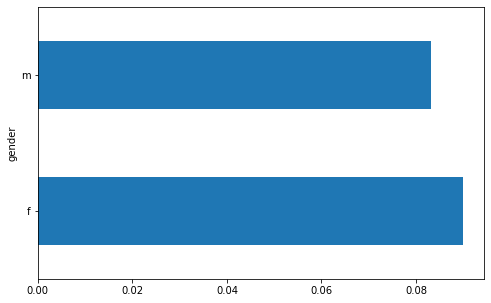

In [21]:
train.groupby('gender')['is_promoted'].mean().plot(kind='barh')

### Recruitment_channel

In [22]:
train['recruitment_channel'].value_counts(normalize=True)

other       0.555503
sourcing    0.423661
referred    0.020836
Name: recruitment_channel, dtype: float64

In [23]:
test['recruitment_channel'].value_counts(normalize=True)

other       0.556748
sourcing    0.424053
referred    0.019200
Name: recruitment_channel, dtype: float64

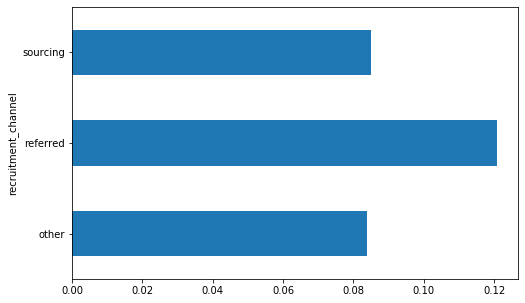

In [24]:
train.groupby('recruitment_channel')['is_promoted'].mean().plot(kind='barh')

### No_of_trainings

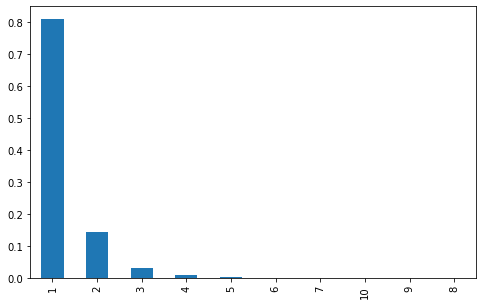

In [25]:
train['no_of_trainings'].value_counts(normalize=True).plot(kind='bar')

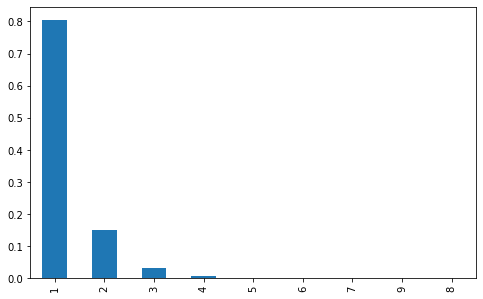

In [26]:
test['no_of_trainings'].value_counts(normalize=True).plot(kind='bar')

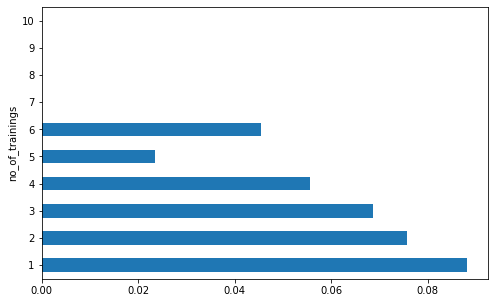

In [27]:
train.groupby('no_of_trainings')['is_promoted'].mean().plot(kind='barh')

### Age

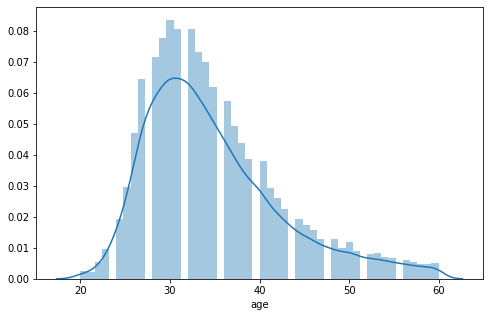

In [28]:
sns.distplot(train['age'])

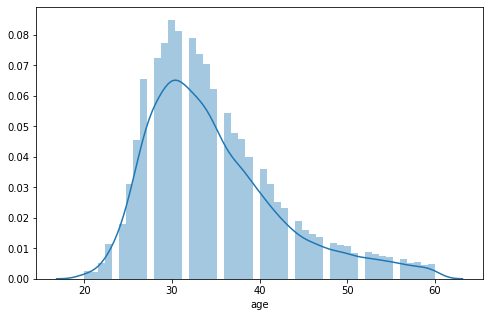

In [29]:
sns.distplot(test['age'])

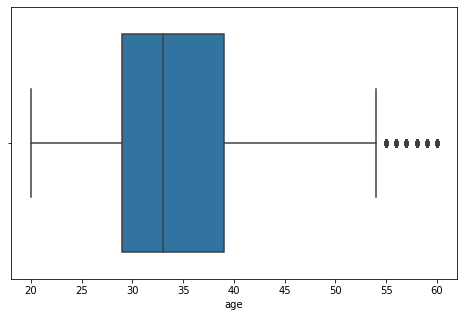

In [30]:
sns.boxplot(train['age'])

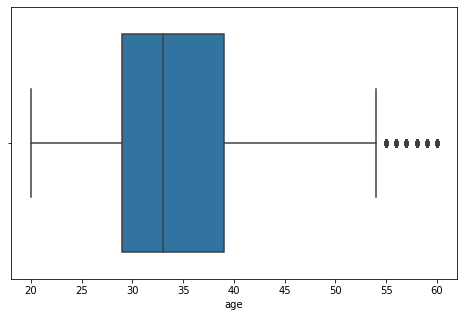

In [31]:
sns.boxplot(test['age'])

In [32]:
train.groupby('is_promoted')['age'].mean()

is_promoted
0    34.844037
1    34.372965
Name: age, dtype: float64

### Previous_year_rating

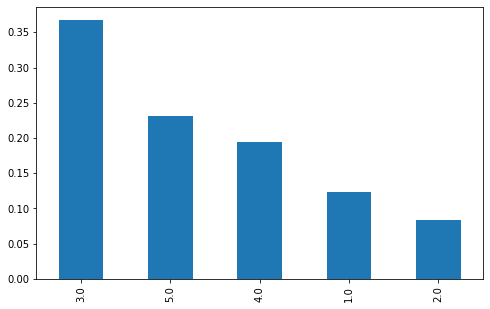

In [33]:
train['previous_year_rating'].value_counts(normalize=True).plot(kind='bar')

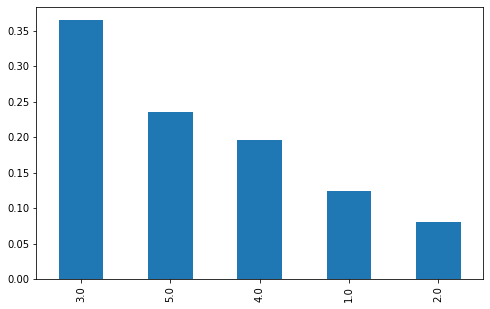

In [34]:
test['previous_year_rating'].value_counts(normalize=True).plot(kind='bar')

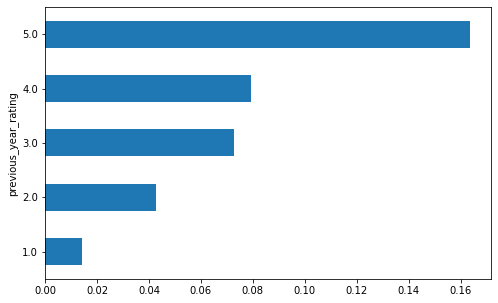

In [35]:
train.groupby('previous_year_rating')['is_promoted'].mean().plot(kind='barh')

In [36]:
train.groupby('is_promoted')['previous_year_rating'].mean()

is_promoted
0    3.267911
1    3.986140
Name: previous_year_rating, dtype: float64

### Length_of_service

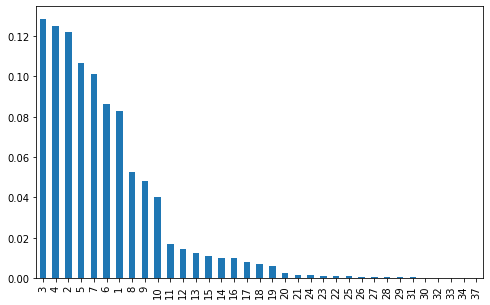

In [37]:
train['length_of_service'].value_counts(normalize=True).plot(kind='bar')

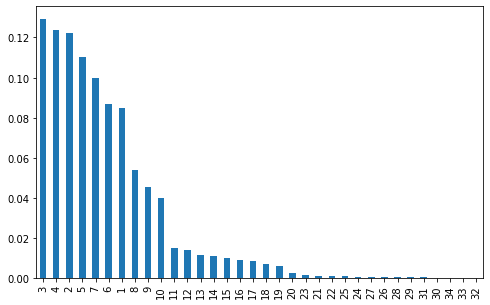

In [38]:
test['length_of_service'].value_counts(normalize=True).plot(kind='bar')

In [39]:
train.groupby('is_promoted')['length_of_service'].mean()

is_promoted
0    5.879398
1    5.716367
Name: length_of_service, dtype: float64

### KPIs_met >80%

In [40]:
train['KPIs_met >80%'].mean()

0.35197416435556855

In [41]:
test['KPIs_met >80%'].mean()

0.358833546189868

In [42]:
train.groupby('KPIs_met >80%')['is_promoted'].mean()

KPIs_met >80%
0    0.039587
1    0.169094
Name: is_promoted, dtype: float64

### Awards_won?

In [43]:
train['awards_won?'].mean()

0.023171799737264635

In [44]:
test['awards_won?'].mean()

0.02277564921243082

### Avg_training_score

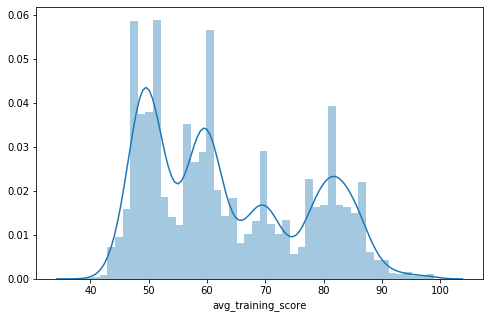

In [45]:
sns.distplot(train['avg_training_score'])

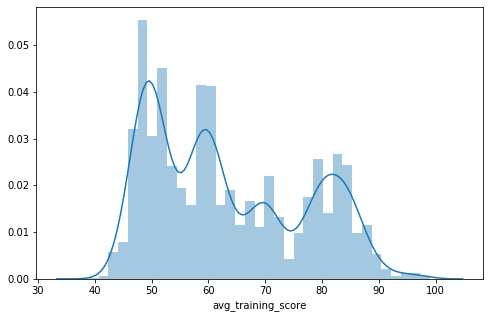

In [46]:
sns.distplot(test['avg_training_score'])

In [47]:
train.groupby('is_promoted')['avg_training_score'].mean()

is_promoted
0    62.647686
1    71.325193
Name: avg_training_score, dtype: float64

### Preprocessing & FE

In [48]:
y = train['is_promoted']
del train['is_promoted']
helper = TrainTestHelper()
data = helper.combine(train, test)

In [49]:
data['department|training'] = data['department'] + np.digitize(data['avg_training_score'], [c * 10 for c in range(3, 11)]).astype(str)
data['kpi|training'] = data['KPIs_met >80%'].astype(str) + np.digitize(data['avg_training_score'], [c * 10 for c in range(3, 11)]).astype(str)
data['department|kpi'] = data['department'] + data['KPIs_met >80%'].astype(str)
data['kpi*rating'] = data['KPIs_met >80%'] * data['previous_year_rating']

data['mean_training_by_department'] = data['department'].map(data.groupby('department')['avg_training_score'].mean())
data['department_training_mean_ratio'] = data['avg_training_score'] / data['mean_training_by_department']

data['mean_rating_by_department'] = data['department'].map(data.groupby('department')['previous_year_rating'].mean())
data['department_rating_mean_ratio'] = data['previous_year_rating'] / data['mean_rating_by_department']

data['mean_kpi_by_department'] = data['department'].map(data.groupby('department')['KPIs_met >80%'].mean())

In [50]:
to_cat = ['department',
          'region',
          'gender',
          'recruitment_channel',
          'department|training',
          'department|kpi',
          'kpi|training']
for c in to_cat:
    data[c] = pd.factorize(data[c])[0]

In [51]:
ed_dict = {'Below Secondary': 0, 'Bachelor\'s': 1, 'Master\'s & above': 2}
data['education'] = data['education'].map(ed_dict)
#data = data.fillna(-1)

In [52]:
train, test = helper.split(data)

In [53]:
###

In [54]:
params = {'app': 'binary',
          'learning_rate': 0.01,
          'num_leaves': 10,
          'feature_fraction': 0.5,
          'lamda_l1': 3,
          'metric': 'binary_logloss'}
cvparams = {'nround': 5000,
            'stopping': 20,
            'verbose': 200,
            'metric': log_loss,
            'folds': KFold(n_splits=5, shuffle=True, random_state=0)}
wiz = LGBWizard(params, cvparams)

In [58]:
wiz.fit(train, y, test, permute=3)

# wiz.params["objective"] = "binary"
# explainer = shap.TreeExplainer(wiz)

Training until validation scores don't improve for 20 rounds
[200]	training's binary_logloss: 0.177852	valid_1's binary_logloss: 0.17423
[400]	training's binary_logloss: 0.164333	valid_1's binary_logloss: 0.161456
[600]	training's binary_logloss: 0.160175	valid_1's binary_logloss: 0.158802
[800]	training's binary_logloss: 0.157644	valid_1's binary_logloss: 0.158
[1000]	training's binary_logloss: 0.155757	valid_1's binary_logloss: 0.157582
Early stopping, best iteration is:
[1024]	training's binary_logloss: 0.155548	valid_1's binary_logloss: 0.15755
Fold 0: 0.15755
Training until validation scores don't improve for 20 rounds
[200]	training's binary_logloss: 0.17738	valid_1's binary_logloss: 0.175561
[400]	training's binary_logloss: 0.163912	valid_1's binary_logloss: 0.163484
[600]	training's binary_logloss: 0.159891	valid_1's binary_logloss: 0.160501
[800]	training's binary_logloss: 0.157477	valid_1's binary_logloss: 0.159412
[1000]	training's binary_logloss: 0.155614	valid_1's binary_l

In [65]:
Mean score: 0.15992
OOF score: 0.15992
Std of score: 0.00328
Mean std of test objects: 0.00579

SyntaxError: invalid syntax (<ipython-input-65-6052e33b4d92>, line 1)

In [59]:
wiz.get_importances()

,permutation,shap,gain,split
department_training_mean_ratio,0.107929,0.0,206583.551605,1759.2
KPIs_met >80%,0.046580,0.0,82544.214013,423.6
avg_training_score,0.013351,0.0,62294.559774,1483.8
kpi*rating,0.009228,0.0,43944.166182,473.8
awards_won?,0.004413,0.0,17526.299924,440.6
kpi|training,0.003672,0.0,19843.790062,494.4
department_rating_mean_ratio,0.002949,0.0,15010.347594,1032.8
region,0.002394,0.0,8872.591027,1304.0
age,0.002190,0.0,6924.444135,1243.0
department|training,0.002066,0.0,71402.208919,631.8


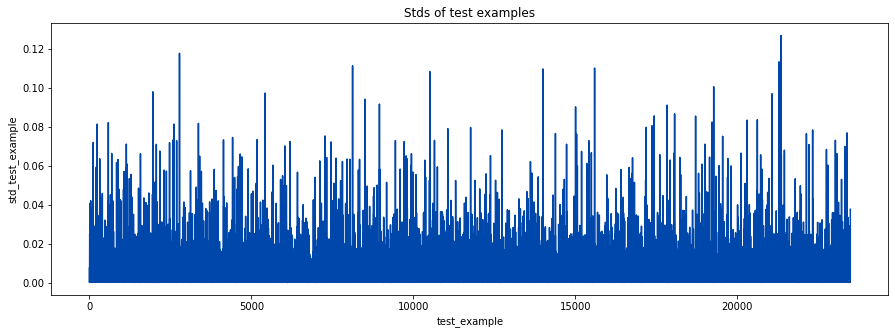

In [60]:
wiz.plot_prediction_std()

In [81]:
f1_score(y, 1 * (wiz.cvpred > 0.24))

0.532926519196542

In [75]:
sub['is_promoted'] = wiz.pred
sub.to_csv('lgb_starter_0.533CV_mean_enc.csv', index=False)

In [62]:
oof = pd.DataFrame()
oof['is_promoted'] = wiz.cvpred

In [63]:
# 4 Dima to ensemble
oof.to_csv('oof.csv', index=False)
sub.to_csv('sub.csv', index=False)